# Notebook to understand what is going on inside K prediction

In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


In [2]:
# load x data dumped during run of test.py
x = torch.load('../x.pt')
print(x.shape)

torch.Size([20, 2, 68])


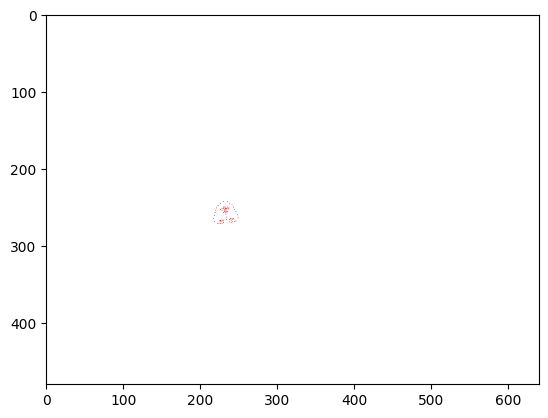

In [3]:
# visualize data in a raw form to get understanding of X & Y axis
img = np.ones((480, 640, 3), dtype=np.uint8) * 255
keypoints = x[10, :, :]
for i in range(keypoints.shape[1]):
    keypoint = keypoints[:, i]
    keypoint = keypoint.numpy().astype(np.int32)
    img[keypoint[1], keypoint[0]] = [255, 0, 0]

plt.imshow(img)
plt.show()

torch.Size([100, 2, 68])


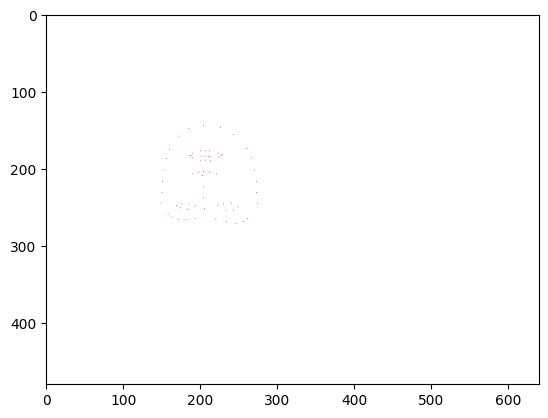

In [4]:
# load data dumped to tensor from WET session - to investigate if the data look similar to what was used by FaceCalibration
x_wet = torch.load('../x_wet.pt')
print(x_wet.shape)

# visualize data in a raw form to get understanding of X & Y axis
img = np.ones((480, 640, 3), dtype=np.uint8) * 255
keypoints = x_wet[1, :, :]
for i in range(keypoints.shape[1]):
    keypoint = keypoints[:, i]
    keypoint = keypoint.numpy().astype(np.int32)
    img[keypoint[1], keypoint[0]] = [255, 0, 0]

plt.imshow(img)
plt.show()

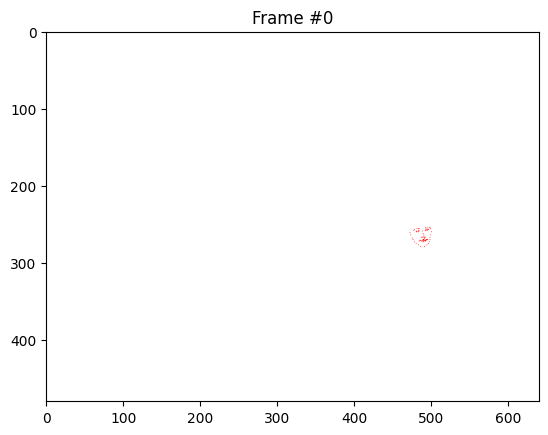

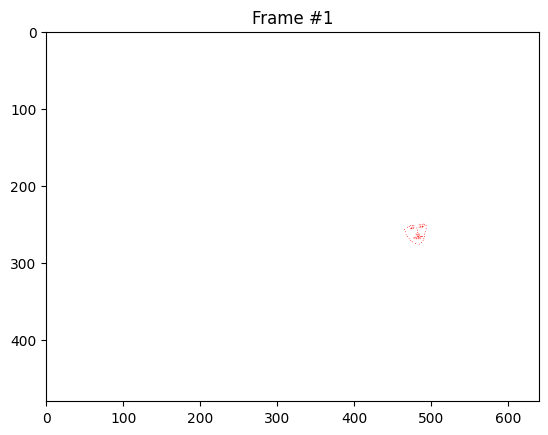

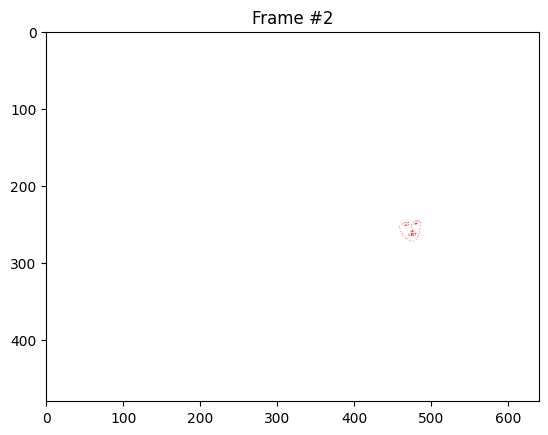

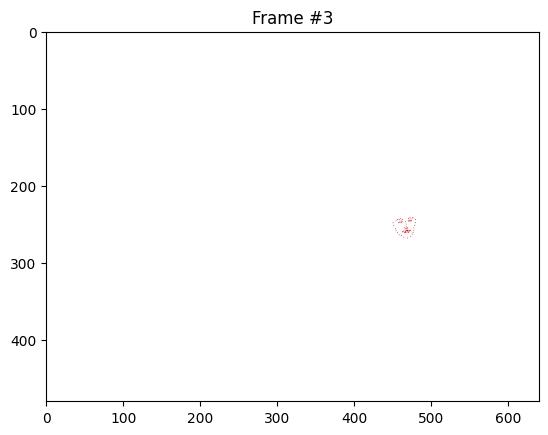

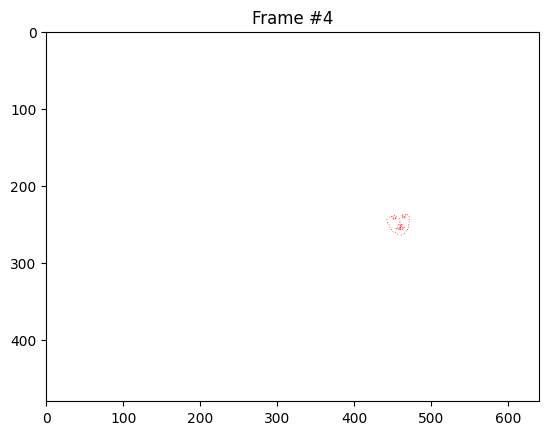

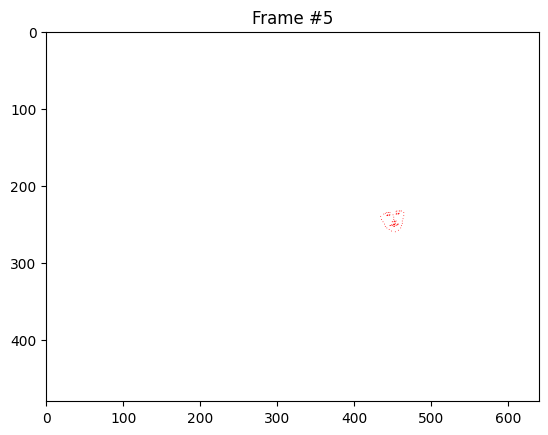

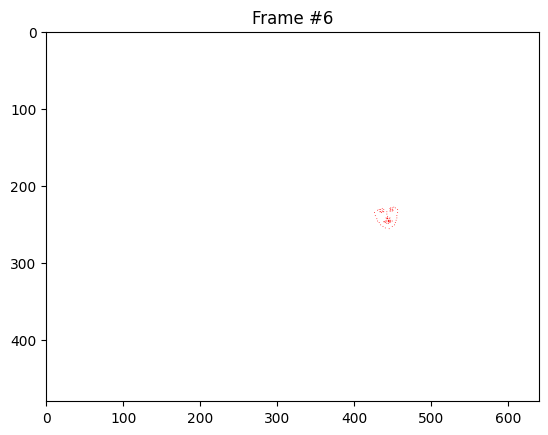

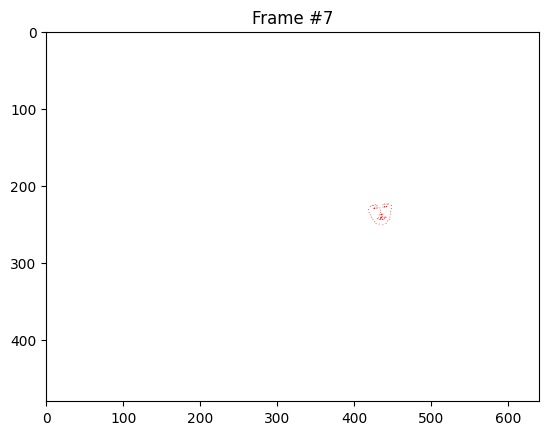

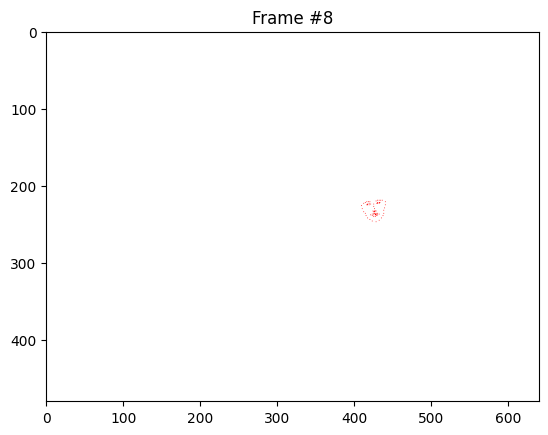

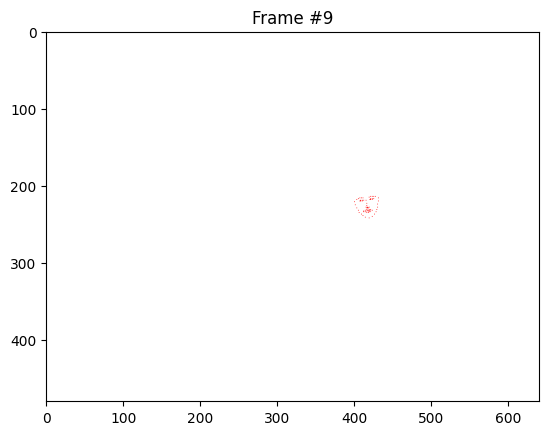

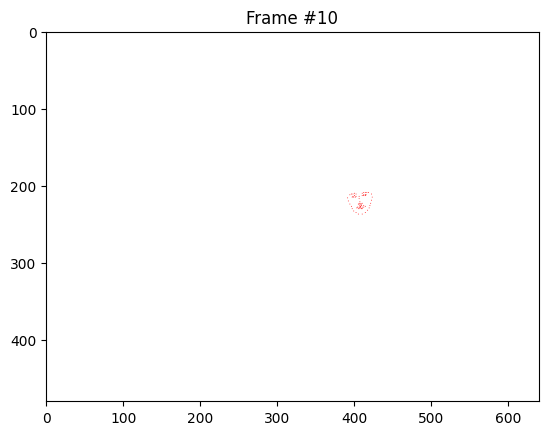

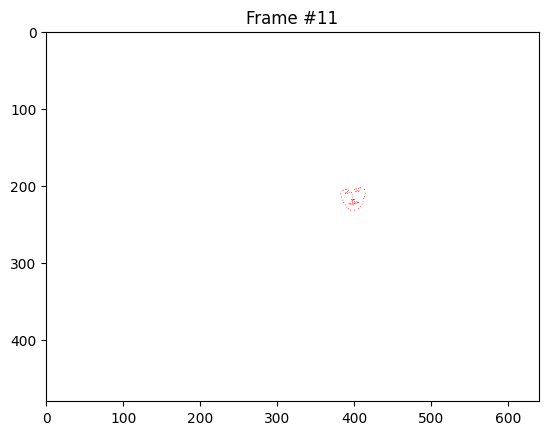

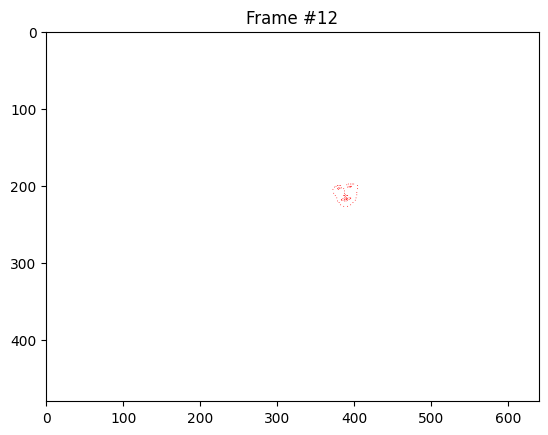

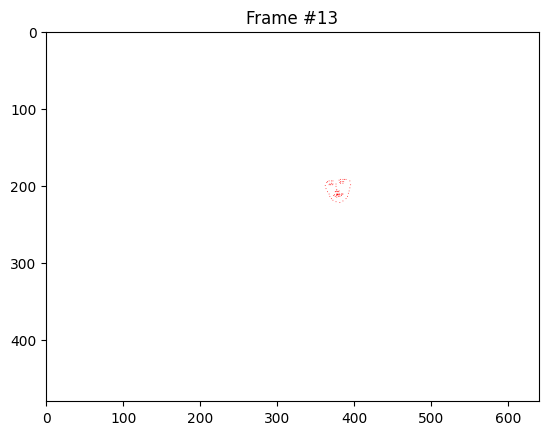

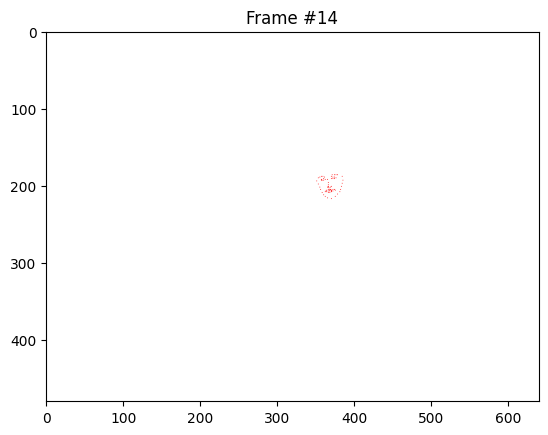

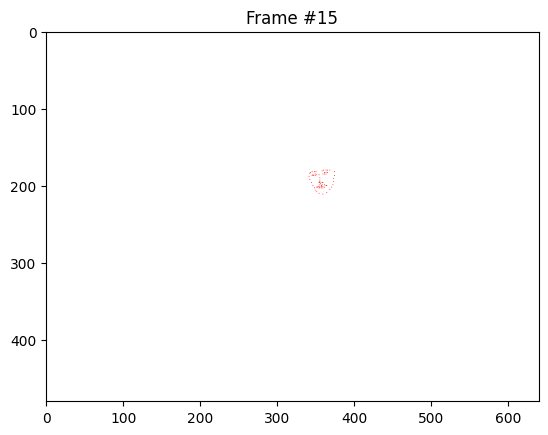

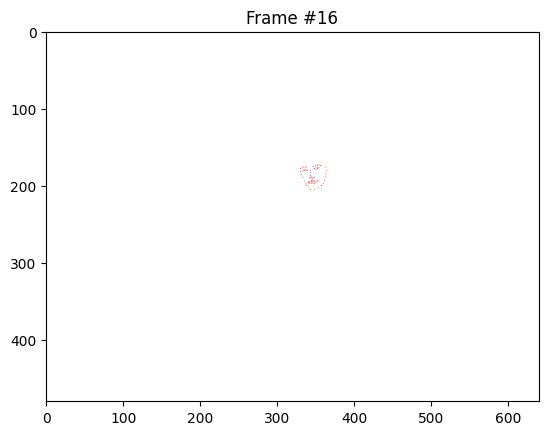

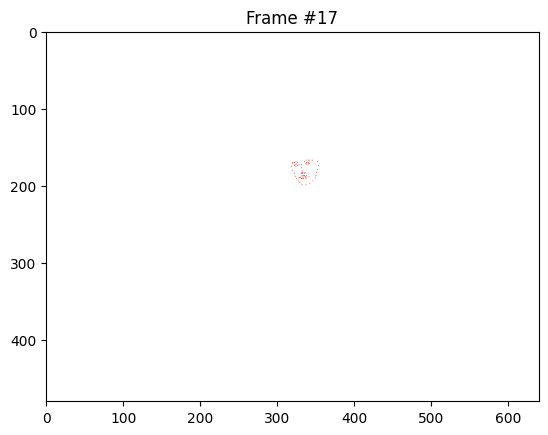

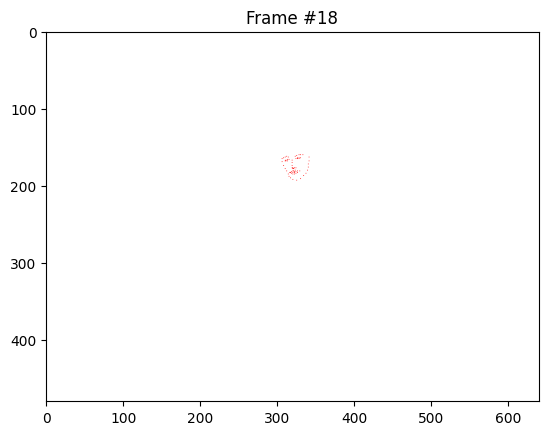

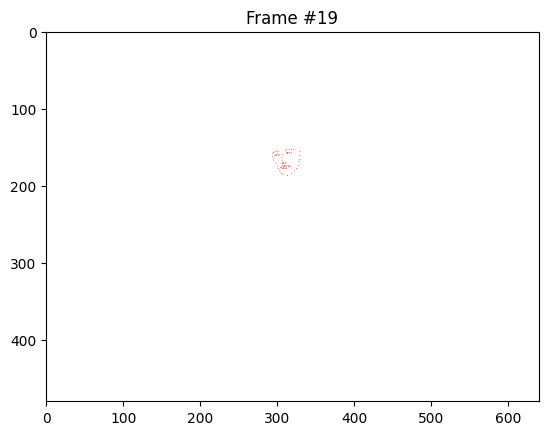

In [5]:
# visualize the data
for i in range(x.shape[0]):
    # set the entire image to white color
    img = np.ones((480, 640, 3), dtype=np.uint8) * 255
    for j in range(x.shape[2]):
        pixel = x[i, :, j]
        pixel = pixel.numpy().astype(np.int32)
        img[480 - pixel[1], 640 - pixel[0]] = [255, 0, 0]
    plt.imshow(img)
    plt.title(f'Frame #{i}')
    plt.show()

## Identify landmarks location

Select an example data frame with face landmarks

(2, 68)
217
243
249
271
32 28


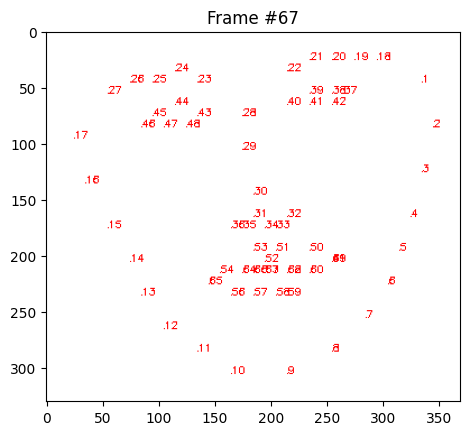

In [6]:
FRAME_INDEX = 10

# convert landmarks locations from tensor to NumPy array
landmarks = x[FRAME_INDEX, :, :].numpy().astype(np.int32)

# get the value range for landmarks
print(landmarks.shape)
min_x, min_y = np.min(landmarks, axis=1)
print(min_x)
print(min_y)
max_x, max_y = np.max(landmarks, axis=1)
print(max_x)
print(max_y)

# define the image as a crop of original image frame based on min & max location of landmarks for better visualization
width = max_x - min_x
height = max_y - min_y
print(width, height)

RESOLUTION_RATIO = 10.0

# set the entire image to white color
width = width * 10 + 50
height = height * 10 + 50
img = np.ones((height, width, 3), dtype=np.uint8) * 255

for i in range(landmarks.shape[1]):
    pixel = landmarks[:, i]
    # draw landmark
    # NOTE: We flip the coordinates of the landmarks from left to right and from top to bottom for better visualization.
    landmark_x = width - ((pixel[0] - min_x) * 10 + 25)
    landmark_y = height - ((pixel[1] - min_y) * 10 + 25)
    img[landmark_y, landmark_x] = [255, 0, 0]
    # draw landmark index
    img = cv2.putText(img, f'{i+1}', (landmark_x, landmark_y), cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, color=(255, 0, 0))

plt.imshow(img)
plt.title(f'Frame #{i}')
plt.show()

## Identify face landmarks mapping between Face Blaze (WET) & dlib (FaceCalibration)

In [7]:
# load example frame from WET data
# filepath = '../wet/data1/frame_kpts_1.npy'
filepath = '../wet/data2/frame_kpts_1.npy'

with open(filepath, 'rb') as f:
    frame = np.load(f)
    face_keypoints = np.load(f)

assert frame is not None
assert len(face_keypoints) == 478

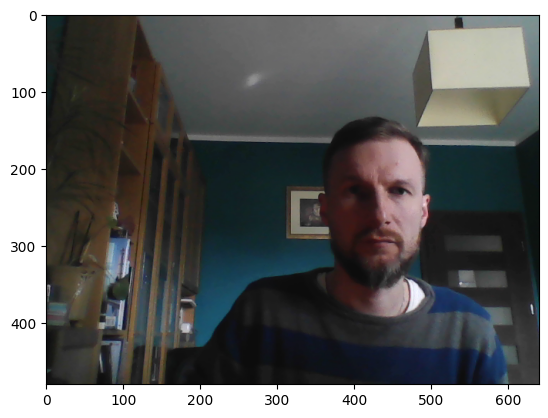

In [8]:
# display Face Blaze landmarks
img = frame.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i, landmark in enumerate(face_keypoints):
    if i == 0:
        img[int(landmark[1]), int(landmark[0])] = [255, 0, 0]
plt.imshow(img)
plt.show()

In [9]:
# define a mapping between dlib & Face Blaze landmarks
DLIB_2_FACE_BLAZE_MAPPING = [
    # face outline
    127,
    234,
    93,
    132,
    58,
    172,
    150,
    176,
    152,
    400,
    379,
    397,
    288,
    361,
    323,
    454,
    356,
    # left eyebrow
    70,
    63,
    105,
    66,
    107,
    # right eyebrow
    336,
    296,
    334,
    293,
    300,
    # nose
    168,
    197,
    5,
    1,
    98,
    97,
    2,
    326,
    327,
    # left eye
    33,
    160,
    158,
    133,
    153,
    144,
    # right eye
    362,
    385,
    387,
    263,
    373,
    380,
    # lips
    61,
    40,
    37,
    0,
    267,
    270,
    291,
    321,
    314,
    17, 84,
    91,
    78,
    82,
    13,
    312,
    308,
    317,
    14,
    87,
]

assert len(DLIB_2_FACE_BLAZE_MAPPING) == 68


In [10]:
from numpy.typing import NDArray

# extract dlib landmakrs out of Face Blaze landmarks and visualize

def face_blaze_2_dlib(fb_landmarks: NDArray[np.float32]) -> NDArray[np.float32]:
    """extract dlib's landmarks out of Face Blaze landmarks

    Args:
        fb_landmarks: FaceBlaze 478 landmarks

    Returns:
        dlib landmarks
    """

    assert fb_landmarks.shape == (478, 2)

    dlib_landmarks = np.array([fb_landmarks[i] for i in DLIB_2_FACE_BLAZE_MAPPING], dtype=np.float32)
    assert dlib_landmarks.shape == (68, 2)
    return dlib_landmarks


In [11]:
dlib_landmarks = face_blaze_2_dlib(face_keypoints)

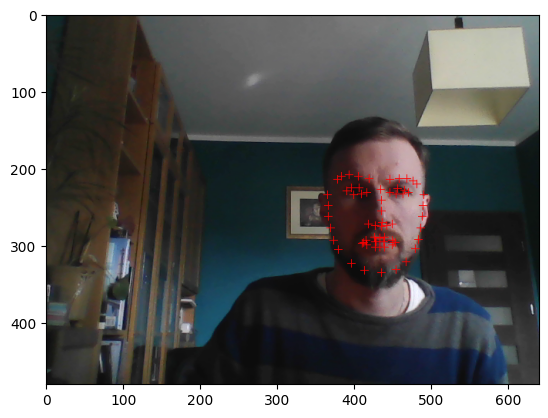

In [12]:
# visualize dlib landmarks
img = frame.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i, landmark in enumerate(dlib_landmarks):
    img = cv2.drawMarker(img, np.array(landmark, dtype=int), color=(255, 0, 0), markerSize=10)

plt.imshow(img)
plt.show()